The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [ ]:
# TODO : import the dataset

from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip AB_Test_Results.zip

Archive:  AB_Test_Results.zip
  inflating: AB_Test_Results/AB_Test_Results.csv  


In [ ]:
# TODO : take a quick look at the data
df = pd.read_csv('/content/AB_Test_Results/AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
df.isna().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


In [ ]:
df.duplicated().sum()

2067

In [ ]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [ ]:
df['VARIANT_NAME'].value_counts()

,count
VARIANT_NAME,
variant,5016
control,4984


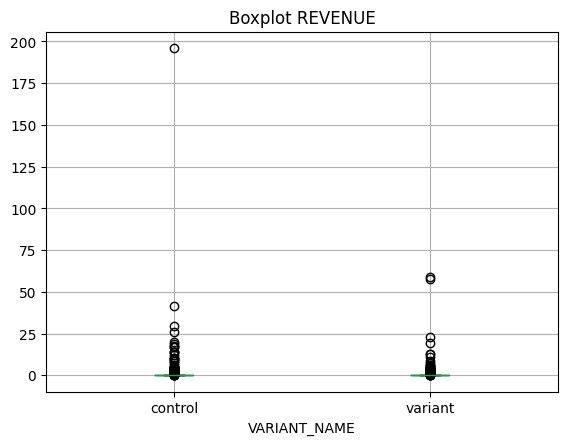

In [ ]:
import matplotlib.pyplot as plt

df.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Boxplot REVENUE")
plt.suptitle("")
plt.show()

Let's see if there are users who have two A/B test groups

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user
groups_of_users = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
dist = groups_of_users.value_counts() #distrib of number of unique groups
dist

,count
VARIANT_NAME,
1,4783
2,1541


In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
# 1541 users are in two groups (both in control and variant). This is an error, as the user should only be in one group as part of the correct A/B testing.

What can you observe ? Should we exclude these users ? Why ?

In [ ]:
# We need to identify these users and exclude them from jne group.
# In order for the test to be correct.

In [ ]:
# TODO : users have 1 A/B test group ?

users_one_group = groups_of_users[groups_of_users == 1]
users_one_group
# TODO : Take only these users
cleaned_df = df[df['USER_ID'].isin(users_one_group.index)]

In [ ]:
# TODO : Leave only records with users with the 1st ab test group
len(cleaned_df)



6070

In [ ]:
# TODO : Check that the number of users matches what it was before the exception
df['USER_ID'].nunique()
cleaned_df['USER_ID'].nunique()
print('Number of unique users before cleaning:', df['USER_ID'].nunique())
print('Number of records after:', cleaned_df['USER_ID'].nunique())

Number of unique users before cleaning: 6324
Number of records after: 4783


In [ ]:
#The number of users has changed.

Let's see how the data is distributed

<Figure size 800x500 with 0 Axes>

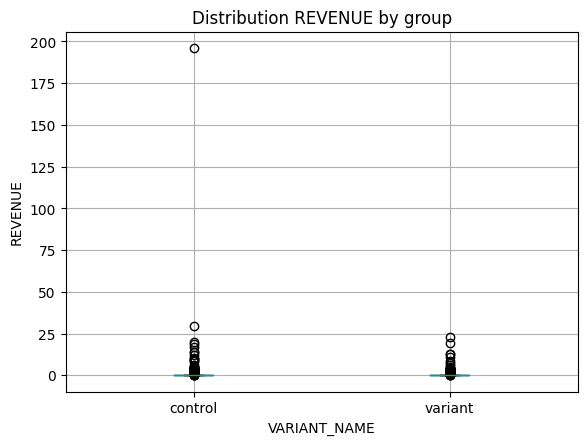

In [ ]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(8, 5))
cleaned_df.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Distribution REVENUE by group")
plt.suptitle("")
plt.ylabel("REVENUE")
plt.xlabel("VARIANT_NAME")
plt.show()


It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order
cleaned_df.sort_values(by='REVENUE', ascending=False)


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3366,1189,control,0.00
3363,2051,variant,0.00
3362,3276,variant,0.00
3360,1608,variant,0.00


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier
# Yes its 196.01

We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

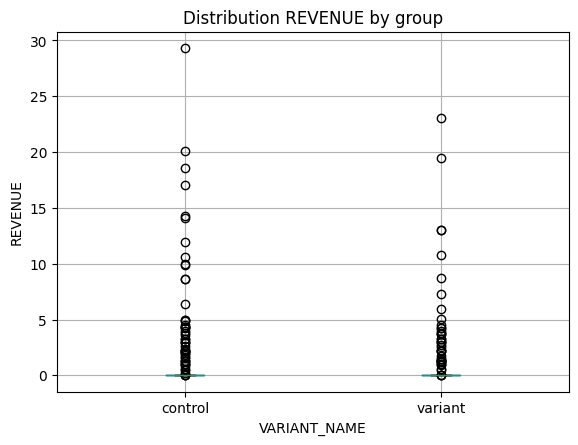

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
cleaned_df = cleaned_df[cleaned_df['REVENUE'] < 196.01]
cleaned_df.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Distribution REVENUE by group")
plt.suptitle("")
plt.ylabel("REVENUE")
plt.xlabel("VARIANT_NAME")
plt.show()


What can you say about the users and their purchases ?

The majority of users in both control and variant groups have very low or zero revenue
There are a few users in both groups with significantly higher revenue, which are show as outliers in the plot
Revenue distribution is highly right-skewed

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue
zero_users = cleaned_df[cleaned_df['REVENUE'] == 0]
positive_users = cleaned_df[cleaned_df['REVENUE'] > 0]
print('Number of users with zero revenue:', len(zero_users))
print('Number of users with positive revenue:', len(positive_users))

Number of users with zero revenue: 5973
Number of users with positive revenue: 96


Can a user have records with both zero and positive revenue ?

Yes its possible

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

data = cleaned_df.groupby('USER_ID').agg({'VARIANT_NAME': 'first', 'REVENUE': 'sum'}).reset_index()
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0


In [ ]:
print(len(cleaned_df))
print(len(data))

6069
4782


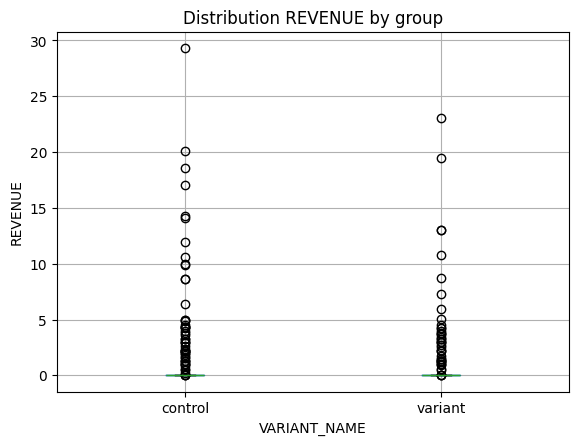

In [ ]:
# TODO : Visualize the resulting distribution of the data again.
data.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Distribution REVENUE by group")
plt.suptitle("")
plt.ylabel("REVENUE")
plt.xlabel("VARIANT_NAME")
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups
metrics_by_groups = data.groupby('VARIANT_NAME').agg({'REVENUE': ['mean', 'median', 'std', 'min', 'max']}).reset_index()
metrics_by_groups.columns = ['VARIANT_NAME', 'MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']
print(metrics_by_groups)

# TODO : create two additional metrics to see relative changes
control_avg = metrics_by_groups.loc[metrics_by_groups['VARIANT_NAME'] == 'control', 'MEAN'].values[0]
variant_avg = metrics_by_groups.loc[metrics_by_groups['VARIANT_NAME'] == 'variant', 'MEAN'].values[0]
metrics_by_groups['RELATIVE_CHANGE'] = (metrics_by_groups['MEAN'] - control_avg) / control_avg
control_total = metrics_by_groups.loc[metrics_by_groups['VARIANT_NAME'] == 'control', 'MEAN'].values[0]
variant_total = metrics_by_groups.loc[metrics_by_groups['VARIANT_NAME'] == 'variant', 'MEAN'].values[0]
metrics_by_groups['RELATIVE_TOTAL_CHANGE'] = (variant_total - control_total) / control_total
print(metrics_by_groups)

# TODO : add them to the rest of the metrics in a separate group
# done

  VARIANT_NAME      MEAN  MEDIAN       STD  MIN    MAX
0      control  0.114923     0.0  1.162495  0.0  29.32
1      variant  0.074935     0.0  0.858207  0.0  23.04
  VARIANT_NAME      MEAN  MEDIAN       STD  MIN    MAX  RELATIVE_CHANGE  \
0      control  0.114923     0.0  1.162495  0.0  29.32          0.00000   
1      variant  0.074935     0.0  0.858207  0.0  23.04         -0.34795   

   RELATIVE_TOTAL_CHANGE  
0               -0.34795  
1               -0.34795  


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?


decrease in total income in the test group by 34.8% compared to the control group

The average check in the test group decreased by 34.8% compared to the control group.

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups
paying_users = data[data['REVENUE'] > 0]
metrics_by_groups_paying = paying_users.groupby('VARIANT_NAME').agg({'REVENUE': ['mean', 'median', 'std', 'min', 'max']}).reset_index()
metrics_by_groups_paying.columns = ['VARIANT_NAME', 'MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']


# TODO : create two additional metrics to see relative changes
control_mean_paying = metrics_by_groups_paying.loc[metrics_by_groups_paying['VARIANT_NAME'] == 'control', 'MEAN'].values[0]
variant_mean_paying = metrics_by_groups_paying.loc[metrics_by_groups_paying['VARIANT_NAME'] == 'variant', 'MEAN'].values[0]
control_total_paying = metrics_by_groups_paying.loc[metrics_by_groups_paying['VARIANT_NAME'] == 'control', 'MEAN'].values[0]
variant_total_paying = metrics_by_groups_paying.loc[metrics_by_groups_paying['VARIANT_NAME'] == 'variant', 'MEAN'].values[0]

# TODO : add them to the rest of the metrics in a separate group
metrics_by_groups_paying['RELATIVE_CHANGE'] = (metrics_by_groups_paying['MEAN'] - control_mean_paying) / control_mean_paying
metrics_by_groups_paying['RELATIVE_TOTAL_CHANGE'] = (variant_total_paying - control_total_paying) / control_total_paying
print(metrics_by_groups_paying)

  VARIANT_NAME      MEAN  MEDIAN       STD   MIN    MAX  RELATIVE_CHANGE  \
0      control  5.180189    2.99  5.942771  0.02  29.32         0.000000   
1      variant  4.269524    2.97  4.962253  0.02  23.04        -0.175798   

   RELATIVE_TOTAL_CHANGE  
0              -0.175798  
1              -0.175798  


Let's look at the distributions of all and only paying users

<ipython-input-58-4f45d31b7831>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[data['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-58-4f45d31b7831>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[data['VARIANT_NAME'] == 'variant', 'RE

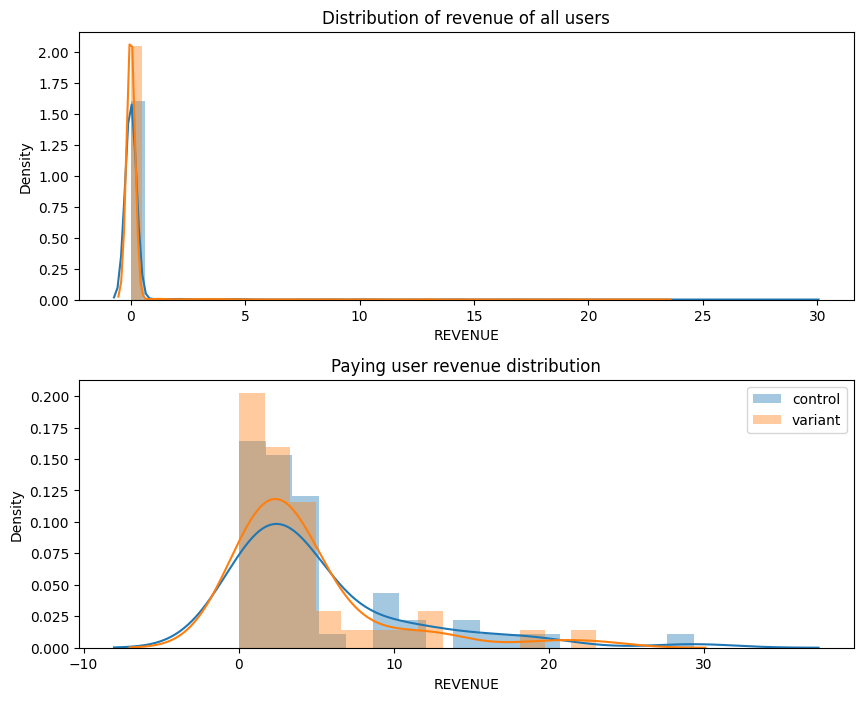

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(data.loc[data['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(data.loc[data['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(paying_users.loc[(paying_users['VARIANT_NAME'] == 'control') & (paying_users['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(paying_users.loc[(paying_users['VARIANT_NAME'] == 'variant') & (paying_users['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

# H0: The data is normally distributed
# H1: The data is not normally distributed

control = data.loc[data['VARIANT_NAME'] == 'control', 'REVENUE']
variant = data.loc[data['VARIANT_NAME'] == 'variant', 'REVENUE']

stat, p = shapiro(control)

print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')




Statistics=0.075, p=0.000
Sample does not look Gaussian (reject H0)


Is the null hypothesis about the normal distribution of the data rejected ?

Yes

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(data['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

stat, p = mannwhitneyu(control, variant, alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=2871768.000, p=0.248
Same distribution (fail to reject H0)


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

control_paying = paying_users.loc[paying_users['VARIANT_NAME'] == 'control', 'REVENUE']
variant_paying = paying_users.loc[paying_users['VARIANT_NAME'] == 'variant', 'REVENUE']

stat, p = mannwhitneyu(control, variant)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=2871768.000, p=0.248
Same distribution (fail to reject H0)


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
data_control = data.loc[data['VARIANT_NAME'] == 'control', 'REVENUE'].values
data_variant = data.loc[data['VARIANT_NAME'] == 'variant', 'REVENUE'].values
print(type(data_control))
print(type(data_variant))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# TODO : Generate samples for all users

control_samples = get_bootstrap_samples(data_control)
variant_samples = get_bootstrap_samples(data_variant)
control_means = np.mean(control_samples, axis=1)
variant_means = np.mean(variant_samples, axis=1)

In [ ]:
# TODO : Generate samples for only paying users
paying_control = paying_users.loc[paying_users['VARIANT_NAME'] == 'control', 'REVENUE'].values
paying_variant = paying_users.loc[paying_users['VARIANT_NAME'] == 'variant', 'REVENUE'].values

control_paying_samples = get_bootstrap_samples(paying_control)
variant_paying_samples = get_bootstrap_samples(paying_variant)

control_paying_means = np.mean(control_paying_samples, axis=1)
variant_paying_means = np.mean(variant_paying_samples, axis=1)


Let's look at the distribution of means in the ab test groups

<ipython-input-83-8405f26633b9>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_means, shade=True, label='All Users - Control', color='blue')
<ipython-input-83-8405f26633b9>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(variant_means, shade=True, label='All Users - Variant', color='orange')
<ipython-input-83-8405f26633b9>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_paying_means, shade=True, label='Paying Users - Control', color='green')
<ipython-input-83-8405f26633b9>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.

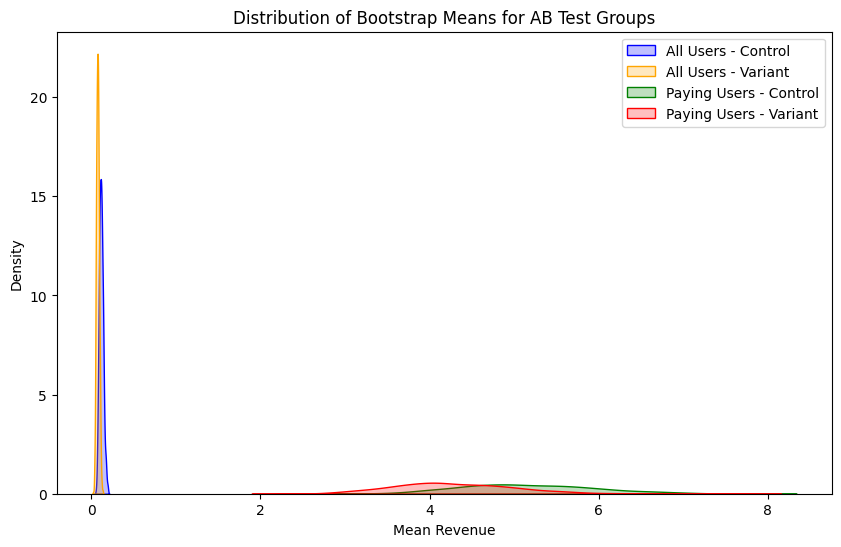

In [ ]:
plt.figure(figsize=(10, 6))

# For all users
sns.kdeplot(control_means, shade=True, label='All Users - Control', color='blue')
sns.kdeplot(variant_means, shade=True, label='All Users - Variant', color='orange')

# For paying users
sns.kdeplot(control_paying_means, shade=True, label='Paying Users - Control', color='green')
sns.kdeplot(variant_paying_means, shade=True, label='Paying Users - Variant', color='red')

plt.title('Distribution of Bootstrap Means for AB Test Groups')
plt.xlabel('Mean Revenue')
plt.ylabel('Density')
plt.legend()
plt.show()

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, fill=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
diff = variant - control
print(diff)


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4777   NaN
4778   NaN
4779   NaN
4780   NaN
4781   NaN
Name: REVENUE, Length: 4782, dtype: float64


IndexError: list index out of range

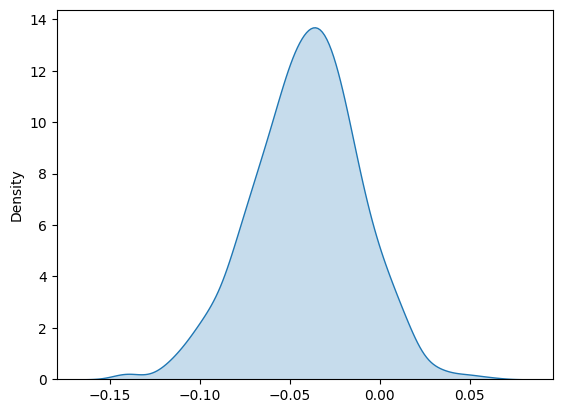

In [ ]:
control_means = np.mean(control_samples, axis=1)
variant_means = np.mean(variant_samples, axis=1)

plot_distribution_and_stat_intervals(variant_means, control_means, title='All Users')


IndexError: list index out of range

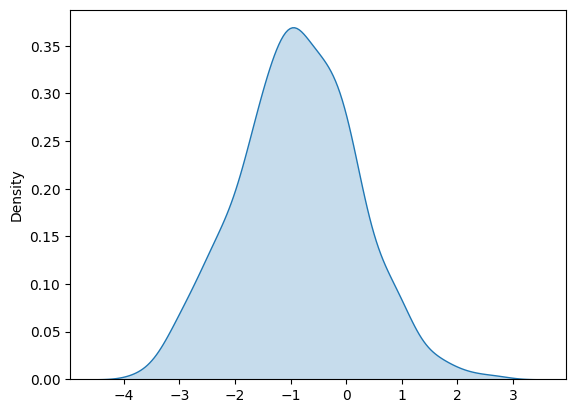

In [ ]:
control_paying_means = np.mean(control_paying_samples, axis=1)
variant_paying_means = np.mean(variant_paying_samples, axis=1)

plot_distribution_and_stat_intervals(variant_paying_means, control_paying_means, title='Paying Users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

There is no difference in average income between the variant and control groups, or it is statistically insignificant.

The graphs show that the changes made to variant did not result in a significant difference in average income between control and variant.
